In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize 
import pandas as pd
import statsmodels.api as sm
from pykalman import KalmanFilter
from quantecon import hamilton_filter
from scipy.optimize import minimize

#### Links to the pages from which data was downloaded:
* GDP: https://fred.stlouisfed.org/series/CLVMNACSCAB1GQNO
* CPI: https://fred.stlouisfed.org/series/NORCPIALLMINMEI
* 3-month interest rate: https://fred.stlouisfed.org/series/IR3TIB01NOM156N

In [2]:
# Read csv files
gdp = pd.read_csv("GDP.csv")
cpi = pd.read_csv("CPI.csv")
rate = pd.read_csv("INTRATE.csv")
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp = gdp.rename(columns={'CLVMNACSCAB1GQNO': 'GDP'})
cpi = cpi.rename(columns={'NORCPIALLMINMEI': 'CPI'})
rate = rate.rename(columns={'IR3TIB01NOM156N': 'RATE'})
# concatenate the columns from  dataframes
result = pd.concat([gdp['GDP'], cpi['CPI'], rate['RATE']], axis=1)

# set index from a chosen dataframe
result.set_index(gdp['DATE'], inplace=True)
result

,GDP,CPI,RATE
DATE,,,
1980-01-01,306144.5,27.366667,12.700000
1980-04-01,299850.6,28.333333,12.466667
1980-07-01,294413.0,29.233333,11.700000
1980-10-01,300813.8,29.900000,12.066667
1981-01-01,306072.2,31.400000,12.166667
...,...,...,...
2021-04-01,762006.3,115.066667,0.246667
2021-07-01,787240.8,116.700000,0.470000
2021-10-01,792364.7,118.066667,0.863333


#### d) Since, all indexes where downloaded on quarterly basis there is no need to aggregate some of the series


#### e) Transform the price index to log and compute the year-on-year difference (inflation). Assume $π^*=2.5$, and plot the inflation gap together with $i_t$. 

In [3]:
# Transform CPI to log
result['log_price']=np.log(result['CPI'])

# the year-on-year difference in log price index
result['inflation'] = result['log_price'].diff(4) * 100
result['inflation']

DATE
1980-01-01          NaN
1980-04-01          NaN
1980-07-01          NaN
1980-10-01          NaN
1981-01-01    13.748217
                ...    
2021-04-01     2.790606
2021-07-01     3.428575
2021-10-01     4.533763
2022-01-01     3.741690
2022-04-01     5.659497
Name: inflation, Length: 170, dtype: float64

In [4]:
# Create new DataFrame from 1981 after computing inflation
result = result.iloc[4:,:]
result.head(5)

,GDP,CPI,RATE,log_price,inflation
DATE,,,,,
1981-01-01,306072.2,31.400000,12.166667,3.446808,13.748217
1981-04-01,307349.9,32.300000,12.533333,3.475067,13.102826
1981-07-01,303493.4,33.200000,13.366667,3.502550,12.724027
1981-10-01,303415.9,33.600000,14.433333,3.514526,11.666759
1982-01-01,305438.9,35.133333,14.333333,3.559150,11.234245


In [5]:
# the mean zero line which would be used for plotting below
mean = np.full((result.shape[0], 1), 0)
final = pd.DataFrame(mean)
final = final.set_index(result.index)

C:\Users\Asus\AppData\Local\Temp\ipykernel_16720\2580423452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['inflation_gap'] = inflation_gap


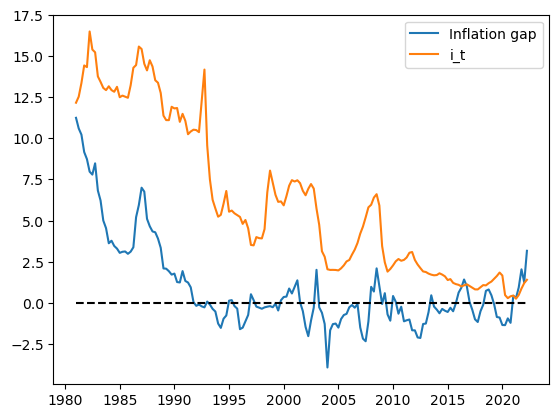

In [6]:
# Compute inflation gap where pi* = 2.5
inflation_gap = result['inflation'] - 2.5
result['inflation_gap'] = inflation_gap 

# Plot inflation gap and i_t
plt.plot(inflation_gap, label='Inflation gap')
plt.plot(result['RATE'], label='i_t')
plt.plot(final[0],'k--')
plt.legend()
plt.show()
result2 = result.copy()

#### Comment: 

As for $i_t$ in this case we took values of interest rate and assume that it could be an $i_t$ from Taylor equation which is the short-term nominal interest rate. From 1990 the $i_t$ flucuated around 0 and there are some period with positive and negative value.

We can see from the plot that the short-term nominal interest rate responds to changes in the inflation gap and typically follows a similar pattern. During the period, the gap between this indexes decreases and by 2020 the short-term nominal interest rate become almost the same as inflation gap.

The general price level in the market will fluctuate over time since the inflation rate is periodically positive and negative. There are times when there is a rise in the level of prices (inflation), and other times when there is a decrease(deflation)

### f)	Use a trend cycle decomposition method and real GDP to produce an output gap. Plot the results and describe why you choose to use the method you used. 


We will use Hamilton filter which can separate cyclical and trend components from a time series. This method was chosen due to its robustness. The filter is made to be resistant to common problems, like volatility and outliers, that might occur while filtering economic and financial data. 

In [7]:
result["GDP"].shape[0]

166

Text(0, 0.5, 'Trend')

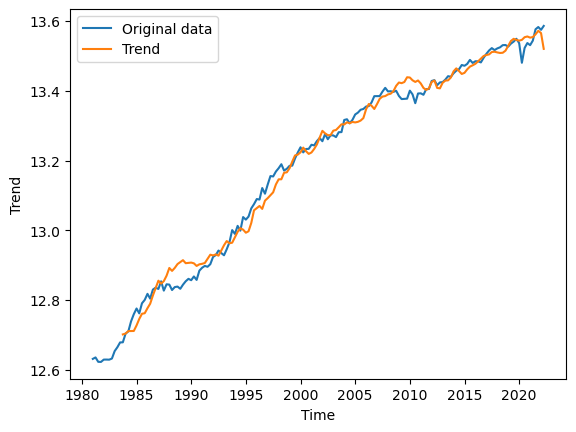

In [8]:
# Hamilton filter
ts = np.log(result["GDP"])  # GDP from this dataframe is already with log transformation
cycle, trend =  hamilton_filter(ts, h = 8, p = 4)
s = pd.Series(trend, index=result["GDP"].index)
fig, ax = plt.subplots()
ax.plot(ts, label='Original data')
ax.plot(s, label = 'Trend')
ax.legend(loc = 'upper left')
ax.set_xlabel("Time")
ax.set_ylabel("Trend")

In [9]:
cyc = pd.Series(cycle, index = result["GDP"].index)
# the mean zero line which would be used for plotting below
mean = np.zeros(result["GDP"].shape[0])
final = pd.DataFrame(cyc)
final['zeros'] = mean
final = final.rename(columns={0: 'cycle'})

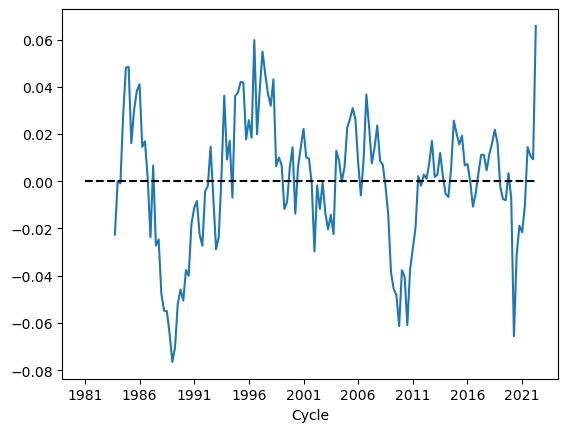

In [10]:
# Plotting cyclical component which is our output gap
fig, ax = plt.subplots()
ax.plot(final['cycle'], label='Cycle')
ax.plot(final['zeros'], 'k--')
years = pd.date_range(start= final.index[0], end= final.index[-1], freq='5AS')
ax.set_xticks(years)
year_labels = [year.strftime('%Y') for year in years]
ax.set_xticklabels(year_labels)
ax.set_xlabel('Cycle')
plt.show()

In [11]:
cyc.shape
cyc1 = cyc.copy()
output_gap = cyc
output_gap.dropna(inplace=True)
output_gap.shape
output_gap

DATE
1983-10-01   -0.022610
1984-01-01   -0.000066
1984-04-01   -0.000917
1984-07-01    0.027493
1984-10-01    0.048074
                ...   
2021-04-01   -0.010335
2021-07-01    0.014468
2021-10-01    0.010824
2022-01-01    0.009271
2022-04-01    0.065783
Length: 155, dtype: float64

In [12]:
# Create final DataFrame
result_final = result.copy()
# Select rows between two specific dates
start_date = '1983-10-01'
result_final = result_final.loc[start_date:]
result_final['output_gap'] = output_gap
result_final

,GDP,CPI,RATE,log_price,inflation,inflation_gap,output_gap
DATE,,,,,,,
1983-10-01,320965.7,40.233333,12.933333,3.694696,7.035491,4.535491,-0.022610
1984-01-01,329089.7,41.000000,13.166667,3.713572,6.118372,3.618372,-0.000066
1984-04-01,331142.9,41.666667,12.933333,3.729701,6.272683,3.772683,-0.000917
1984-07-01,340779.9,42.100000,12.833333,3.740048,5.953654,3.453654,0.027493
1984-10-01,347893.2,42.633333,13.133333,3.752636,5.794058,3.294058,0.048074
...,...,...,...,...,...,...,...
2021-04-01,762006.3,115.066667,0.246667,4.745512,2.790606,0.290606,-0.010335
2021-07-01,787240.8,116.700000,0.470000,4.759607,3.428575,0.928575,0.014468
2021-10-01,792364.7,118.066667,0.863333,4.771249,4.533763,2.033763,0.010824


### g)	Use the Kalman Filter to estimate the State-space model you formulated above

- How I choose to initialize the filter?

We will set initial values for $\theta$ and $B$ as 0.5 and 0.5 respectively. We choose this parameters based on comments and evaluations offered on the FRED (https://fredblog.stlouisfed.org/2014/04/the-taylor-rule/?fbclid=IwAR2bdTaLHtiPQPUexBNwLEif4ooBLy4XWFmusRL-BrSZbPMGh2U9BteKmUE). They also used the values 0.5 for both parameters. In this way, we can stabilize inflation and output gap and receive the balance between these variables and the central bank may show that they are committed to both monetary policy goals by giving inflation and output similar weights.

- F = 0.9, Z = 1 from the assumption of measurment and transition equation 
- c = None, c is a constant from transition equation and from state space represantation is equal to 0
- $ d = 0.5 * (\pi_t - \pi_t^* ) + 0.5 * inflation gap$, where d is a constant from the measurement equation
- H is a 1x1 matrix with the value 1
- Q is a 1x1 matrix with the value 1

In [13]:
def KF(y,Z,F,H,Q,d=None,c=None):
    
    """
    ## Model
    #### Observation eq.:
         y_t = d_t + Z_t*a_t + eps_t,         eps_t ~ N(0,H_t)
     
    #### State eq.:
         a_t = c_t + F_t*a_t-1 + eta_t,        eta_t ~ N(0,Q_t) 
    
    d_t and c_t are the constants of the measurement and state
    equation, respectively. To run the model w/o constants, set
    c_t = None and d_t = None. 
    
    This Kalman filter function allows for time-varying coefficients
    and variance-covariance matrices. However, the function adjusts
    automatically. To estimate a static model, simply input static 
    matrices. 
    
    """
    
    #-----------------------------------------------------------------------

    ############## Preliminaries 
    
    T = y.shape[0] # number of time periods
    n = y.shape[1] # number of variables
    
    # check if inputs are arrays, otherwise transform
    if type(Z)!=numpy.ndarray:
        Z = np.array([Z])
    if type(F)!=numpy.ndarray:
        F = np.array([F])
    if type(H)!=numpy.ndarray:
        H = np.array([H])
    if type(Q)!=numpy.ndarray:
        Q = np.array([Q])
        
    
    # test dimensionality of the problem and adjust objects accordingly
    if len(Z.shape)==1:
        p = 1
        Z = Z[None,:]
    else: 
        p = Z.shape[1] # number of states
    
    if len(F.shape)==1:
        F = F[None,:]
    if len(H.shape)==1:
        H = H[None,:]
    if len(Q.shape)==1:
        Q = Q[None,:]
    
    #### check if model specified with constant
    if c == None:
        c = np.zeros([p,T])
        
    #### check if matrices time-varying
    if max(H.shape)!=T:
        H =  np.repeat(H[:, :, np.newaxis], T, axis=2)
    if max(Q.shape)!=T:
        Q =  np.repeat(Q[:, :, np.newaxis], T, axis=2)  
    if max(F.shape)!=T:
        F =  np.repeat(F[:, :, np.newaxis], T, axis=2)  
    if max(Z.shape)!=T:
        Z =  np.repeat(Z[:, :, np.newaxis], T, axis=2)  

    #-------------------------  Kalman Filter ------------------------------
        
    #### initialize the state mean and variances
    at = np.zeros([p,T])
    att = np.zeros([p,T])
    pt = np.zeros([p,p,T])*np.eye(p)[:,:,None]
    ptt = np.zeros([p,p,T])*np.eye(p)[:,:,None]
    
    #-----------------------------------------------------------------------
    
    ############## Kalman Filter Recursions
    ll = 0
    for t in range(T):
        
        #### Predictions Step (we have update state from previous time)
        at[:,t]   = c[:,t] + F[:,:,t]@att[:,max(1,t-1)]  # conditional mean of pt  (estimate given previos info)
        pt[:,:,t] = F[:,:,t]@ptt[:,:,max(1,t-1)]@F[:,:,t].T + Q[:,:,t] # variance of pt F*PPt*F' + sigma square
        
        
        
        #print("y.t",(y[t,:].T).shape)
        #print("d:", d[t,:].shape)
        #print("Z", Z[:,:,t]@at[:,t].shape) 
        #### Update Step
        v_t        = y[t,:].T- d[t,:] - Z[:,:,t]@at[:,t]       # prediction error (we have new measurment)
        FF         = Z[:,:,t]@pt[:,:,t]@Z[:,:,t].T + H[:,:,t]   # variance 
        K          = (pt[:,:,t]@Z[:,:,t].T)@np.linalg.inv(FF)   # Kalman Gain np.linalg.solve(FF,(pt[:,:,t]@Z[:,:,t].T))
        
        #print('y', y[t,:].T)
        #print('d', d[t,:])
        #print('z:', Z[:,:,t]@at[:,t])
        
        #print("v_t", v_t)
        #print("pt[:,:,t]", pt[:,:,t])
        #print("at[:,t]", at[:,t])
        #print('FF',FF)
        #print('K',K)
        
        att[:,t]   = at[:,t] + K@v_t     # correct prediction 
        ptt[:,:,t] = (np.eye(p)-K@Z[:,:,t])@pt[:,:,t]@(np.eye(p)-K@Z[:,:,t]).T +K@H[:,:,t]@K.T 
     
        ll += multivariate_normal.logpdf(0,v_t,FF)    # log likelihood
    
    #-------------------------  Kalman Smoother ------------------------------
    # here we use the Rauch-Tung-Striebel (RTS) Smoother
    # we will also create random draws from the distribution
    
    #### initialize the state mean and variances
    aT = np.zeros([p,T])
    aT[:,-1] = att[:,-1]
    aS = np.zeros([p,T])
    aS[:,-1] = np.random.multivariate_normal(att[:,-1],ptt[:,:,-1])
    pT = np.zeros([p,p,T])
    pT[:,:,-1] = ptt[:,:,-1]

    for t in reversed(range(T-1)):
        
        #### Backward Smoothing
        V         = (ptt[:,:,t]@F[:,:,t].T)@np.linalg.inv(pt[:,:,t+1])   #np.linalg.solve(pt[:,:,t+1],ptt[:,:,t]@F[:,:,t].T)
        aT[:,t]   = att[:,t] + V@(aT[:,t+1] + c[:,t] -at[:,t+1])
        pT[:,:,t] = ptt[:,:,t] + V@(pT[:,:,t+1]-pt[:,:,t+1])@V.T
        
        #### Backward Sampling
        aS[:,t] = np.random.multivariate_normal(aT[:,t],pT[:,:,t])
        
    #-----------------------------------------------------------------------

    outputs = {'filtered states' : att,
              'smoothed states'  : aT,
              'sampled states'   : aS,
              'filtered CoV'     : ptt,
              'smoothed Cov'     : pT,
              'log-likelihood'   : ll}
    
    return outputs

In [14]:
# Define the function to be optimized
def MLE_KF(parameters, result_final):
    # Unpack parameters
    # Set up Kalman filter with the given parameters
    # Run Kalman filter and retrieve negative log likelihood
    # Return negative log likelihood
    
    
    # Unpack the parameters
    theta = parameters[0]
    beta = parameters[1]
    beta2 = parameters[2]
    # Initialize the Kalman filter
    F =  beta2
    Z =  np.array([1])
    c = None
    d = theta * result_final['inflation_gap'] + beta * result_final['output_gap']
    d = d.values.reshape(-1,1)
    i_t = result_final['RATE'].values.reshape(-1,1)
    H = np.eye(1)
    Q = np.eye(1)
    results = KF(i_t,Z,F,H,Q,d,c=None)
    neglike = -results['log-likelihood'].T
    return neglike

In [15]:
# Set initial guess for parameters that were computed above
initial_parameters = [0.5, 0.5, 0.9]

# Run optimization to find optimal parameters
result = minimize(MLE_KF, initial_parameters, args=(result_final))

# Print the optimal parameters
print("Optimal parameters:", result.x)

C:\Users\Asus\AppData\Local\Temp\ipykernel_16720\528581490.py:131: RuntimeWarning: covariance is not positive-semidefinite.
  aS[:,t] = np.random.multivariate_normal(aT[:,t],pT[:,:,t])


Optimal parameters: [ 1.19575956 -5.74663871  0.98568849]


- Estimated parameters: $\theta \approx  1.2, B = -5.75, F = 0.986$

It's necessary to select values that are appropriate and not too distant from the true values because the performance of the Kalman filter can be sensitive to the initial values of the parameters.

From estimated parameters we can conclude that the central bank may be very responsive to changes in inflation from the target level since $\theta$ is greater than 1. This might mean that stabilizing output is not the central bank's top priority, but rather ensuring low and steady inflation. Since B is negative, the central bank is thought to react to a rise in output by lowering interest rates. 

Whether $\theta \approx  1.2$ and $B=-5.75$ are rational or not relies on a number of variables, including the current state of the economy, inflation expectations, and the objectives of the central bank. However, we can guess that it is not sensible due to the fact that by Taylor in his paper (1993) specifies that the real interest rate should be raised when inflation increases which mean that B has to be positive which in our case is not correct.

In [16]:
# Unpack the parameters
theta = 1.2
beta = -5.75
    
# Initialize the Kalman filter
F =  np.array([1])
Z =  0.9856
c = None
d = theta * result_final['inflation'] + beta * result_final['output_gap']
d = d.values.reshape(-1,1)
i_t = result_final['RATE'].values.reshape(-1,1)
H = np.eye(1)
Q = np.eye(1)
results = KF(i_t,Z,F,H,Q,d,c=None)

In [17]:
results_ham = results.copy()

#### Plot the estimated latent state variable and comment on it in light of the Taylor rule equation above. Is the long-run nominal interest rate high or low today compared to 10-years ago? 

In [18]:
mean2 = np.full((result_final.shape[0], 1), 2.5)
mean3 = pd.DataFrame(mean2)
mean3 = mean3.set_index(result_final.index) # will be used for ploting

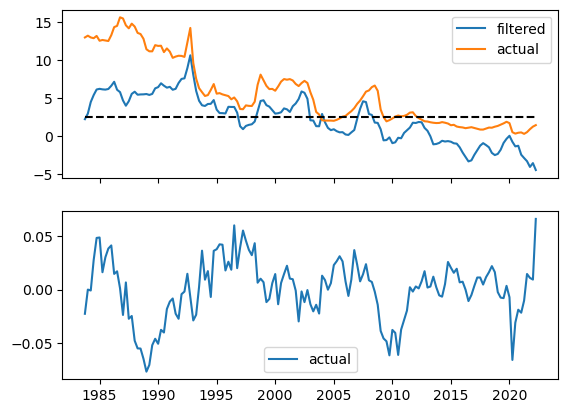

In [19]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

# Plot the first graph on the first subplot
ax1.plot(result_final.index, results['filtered states'].T, label = "filtered")
ax1.plot(result_final['RATE'], label = 'actual')
ax1.plot(mean3[0], 'k--')
ax1.legend()

# Plot the second graph on the second subplot
ax2.plot(result_final['output_gap'], label = 'actual')
plt.legend()
plt.show()

We can observe that during 1985-1990 there is a significant difference between long-run nominal interest rates and actual values. It's possible that the model was unable to completely account for large external shocks of that time. In Norway in the middle of the 1980s oil price collapse had a crucial effect on the Norwegian economy and may have caused the model's forecasts to differ from reality. 

Also, since the COVID-19 pandemic had a huge impact on the world economy in 2020 and central bank were forced to take unusual measures to stabilize the economy and it can be a reason of a moderate difference between these two variables. The sudden shock to the economy increased the volatility of the Taylor rule's key macroeconomic variables, including inflation and the output gap

### h)	Re-do the Kalman Filter estimation procedure using another output gap estimate in the model.  

For taking another output gap we will use HP filter which is often used in economics. However, one of the disadvantages of this filter, is that it has a smoothing parameter $𝜆$ and how to correctly select this parameter is not explicitly stated in the literature.

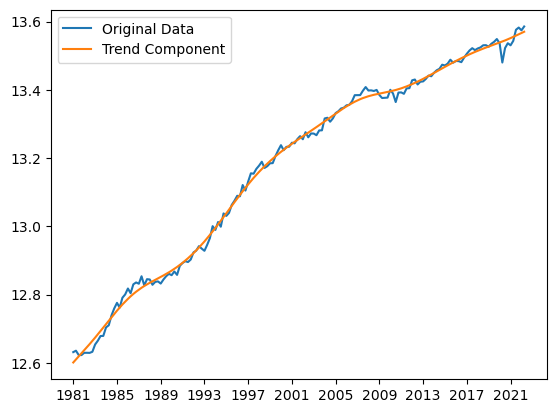

In [20]:
# apply the Hodrick-Prescott filter
cycle, trend = sm.tsa.filters.hpfilter(ts)

# plot the original data and the trend component
fig, ax = plt.subplots()
ax.plot(ts.index, ts, label='Original Data')
ax.plot(ts.index, trend, label='Trend Component')
ax.legend(loc='upper left')
years = pd.date_range(start=ts.index[0], end=ts.index[-1], freq='4AS')
ax.set_xticks(years)
year_labels = [year.strftime('%Y') for year in years]
ax.set_xticklabels(year_labels)
plt.show()

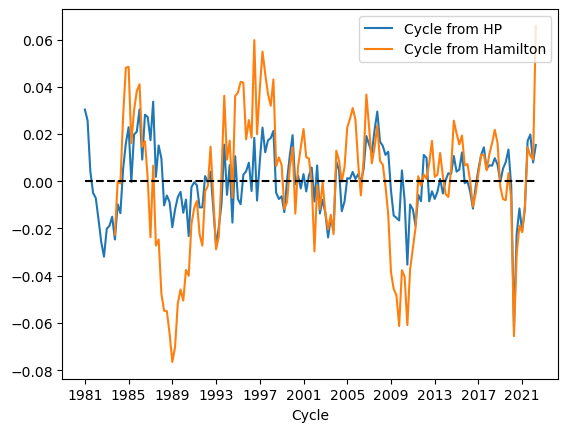

In [21]:
# Plot the new estimate together with the one you used above
fig, ax = plt.subplots()
ax.plot(cycle, label='Cycle from HP')
ax.plot(final['cycle'], label='Cycle from Hamilton')
ax.plot(final['zeros'], 'k--')
years = pd.date_range(start=ts.index[0], end=ts.index[-1], freq='4AS')
ax.set_xticks(years)
year_labels = [year.strftime('%Y') for year in years]
ax.set_xticklabels(year_labels)
ax.set_xlabel('Cycle')
ax.legend()
plt.show()

#### Comment: 
The cyclical component in the Hamilton filter captures the recession period more accurately compared with HP filter, approximately -0.09 and -0.03 respectively. By applying different smoothing parameters the emphasis of the algorithm changes from finding a smoother shape for the trend to accurately fitting the original time series that we observed in Assignment 3. Therefore, it's better to choose the Hamilton filter because we do not need to choose smoothing parameters and it is more suitable for tracking periods of economic crisis or other shocks.

In [22]:
result2['output_gap'] = cycle
result2

,GDP,CPI,RATE,log_price,inflation,inflation_gap,output_gap
DATE,,,,,,,
1981-01-01,306072.2,31.400000,12.166667,3.446808,13.748217,11.248217,0.030363
1981-04-01,307349.9,32.300000,12.533333,3.475067,13.102826,10.602826,0.025725
1981-07-01,303493.4,33.200000,13.366667,3.502550,12.724027,10.224027,0.004276
1981-10-01,303415.9,33.600000,14.433333,3.514526,11.666759,9.166759,-0.004856
1982-01-01,305438.9,35.133333,14.333333,3.559150,11.234245,8.734245,-0.007178
...,...,...,...,...,...,...,...
2021-04-01,762006.3,115.066667,0.246667,4.745512,2.790606,0.290606,-0.011795
2021-07-01,787240.8,116.700000,0.470000,4.759607,3.428575,0.928575,0.017075
2021-10-01,792364.7,118.066667,0.863333,4.771249,4.533763,2.033763,0.019803


In [23]:
# Set initial guess for parameters that were computed above
initial_parameters = [0.5, 0.5, 0.9]

# Run optimization to find optimal parameters
result = minimize(MLE_KF, initial_parameters, args=(result2))

# Print the optimal parameters
print("Optimal parameters:", result.x)

C:\Users\Asus\AppData\Local\Temp\ipykernel_16720\528581490.py:131: RuntimeWarning: covariance is not positive-semidefinite.
  aS[:,t] = np.random.multivariate_normal(aT[:,t],pT[:,:,t])


Optimal parameters: [0.92216405 5.57069092 0.98959916]


 - 	How does this change the estimates of θ and B? 
 
Estimated parameters become: $\theta \approx  0.922, B = 5.57$ and $F = 0.99 (which we will take as 1)$

As we can see both variables will have a positive impact on the interest rate $i_t$ since in this case $\theta$ and B parameters in the Taylor rule equation have the same sign.



In [24]:
# Unpack the parameters
theta = 0.922
beta = 5.57
    
# Initialize the Kalman filter
F = np.array([1])
Z = 1
c = None
d = theta * result2['inflation'] + beta * result2['output_gap']
d = d.values.reshape(-1,1)
i_t = result2['RATE'].values.reshape(-1,1)
H = np.eye(1)
Q = np.eye(1)
results = KF(i_t,Z,F,H,Q,d,c=None)

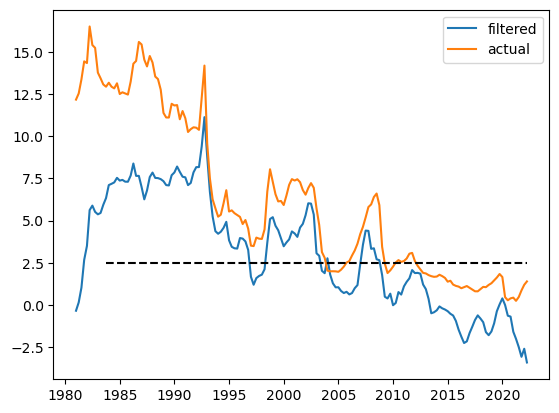

In [25]:
# Plotting the results of HP - filter
plt.plot(result2.index, results['filtered states'].T, label = "filtered")
plt.plot(result2['RATE'], label = 'actual')
plt.plot(mean3[0], 'k--')
plt.legend()

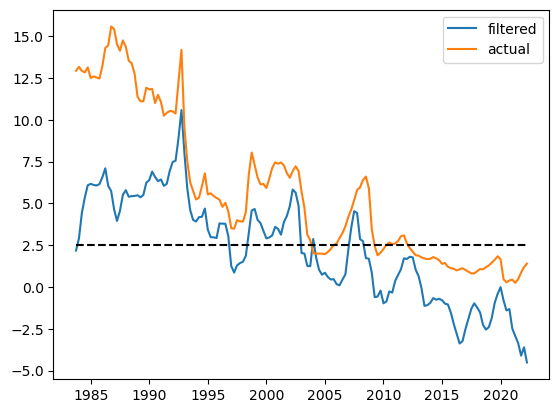

In [26]:
# Plot the Hamilton filter 
plt.plot(result_final.index, results_ham['filtered states'].T, label = "filtered")
plt.plot(result_final['RATE'], label = 'actual')
plt.plot(mean3[0], 'k--')
plt.legend()

 - 	How does this change the estimates of $θ$ and $B$? 
 
Both of our parameters become positive with using HP-filter which is consistent with Taylor proposed setting where both $θ$ and $B$ are positive. Furthermore, it could be seen that the coefficient for output gap is more than inflation gap which means that  that the output gap was given greater weight in this model. The central bank trying to stabilize GDP growth rather than putting too much emphasis on inflation.


- How does this change the estimates of the latent state variable?

Changes in the output gap will have a greater impact on the latent state variable than changes in inflation as they demonstrate the central bank's reaction to shifts in inflation and economic output expansion.